# Create new features within a Pipeline

In this notebook, I show how easy and practical is to create new features Feature-engine and the scikit-learn pipeline.

For this demonstration, we use the UCI Wine Quality Dataset.

The data is publicly available on [UCI repository](https://archive.ics.uci.edu/ml/datasets/Wine+Quality)

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

In [1]:
import feature_engine
feature_engine.__version__

'1.0.2'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline


# import classes from Feature-engine
from feature_engine.creation import MathematicalCombination, CombineWithReferenceFeature

In [3]:
# Load dataset

data = pd.read_csv('winequality-red.csv', sep=';')

print(data.shape)

data.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Exploratory Data Analysis

Let's have a look at the variables and their relationships.

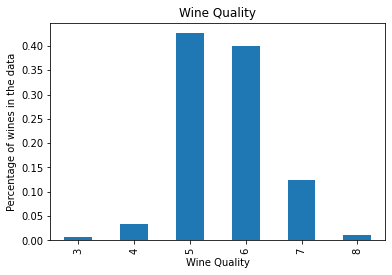

In [4]:
# check how many wines of different qualities there are

# percentage of wines of each quality
(data['quality'].value_counts() / len(data)).sort_index().plot.bar()

# plot
plt.title('Wine Quality')
plt.ylabel('Percentage of wines in the data')
plt.xlabel('Wine Quality')
plt.show()

Most wines are medium to low quality. Only a few of high quality (>6)

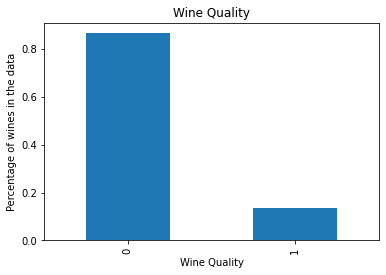

In [5]:
# let's transform the target into binary

# wines with quality below 6 will be considered low quality (0)
data['quality'] = np.where(data['quality'] <= 6, 0, 1)

(data['quality'].value_counts() / len(data)).plot.bar()

plt.title('Wine Quality')
plt.ylabel('Percentage of wines in the data')
plt.xlabel('Wine Quality')
plt.show()

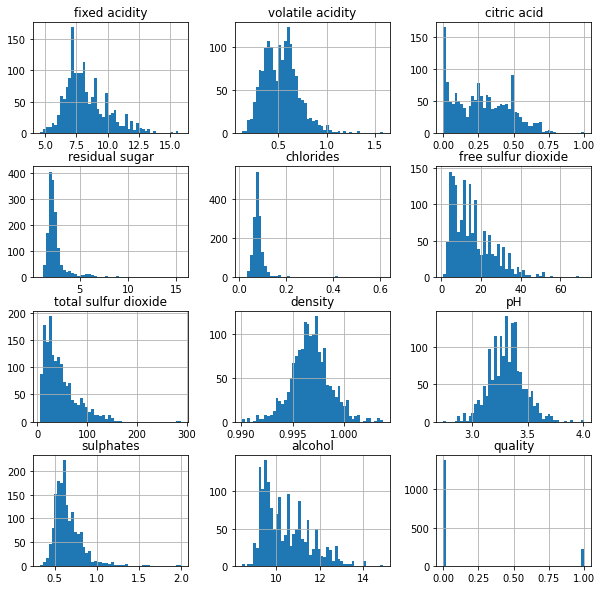

In [6]:
# let's explore variable distributions with histograms

data.hist(bins=50, figsize=(10,10))

plt.show()

All variables are continuous.

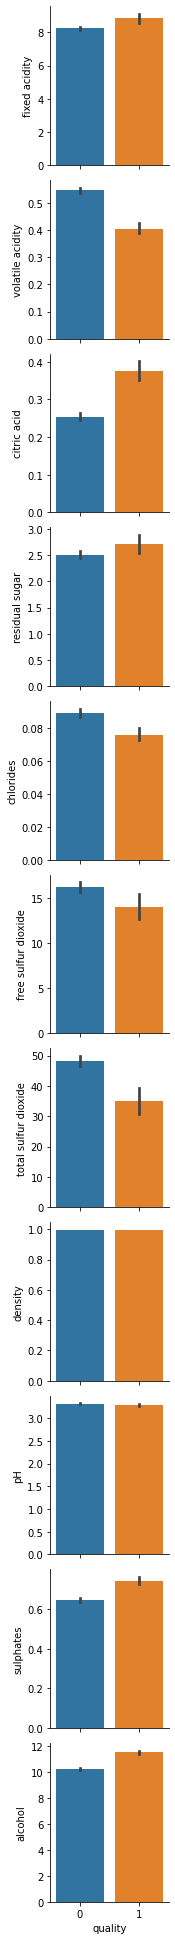

In [7]:
# let's evaluate the mean variable value per wine quality

g = sns.PairGrid(data, x_vars=["quality"], y_vars=data.columns[0:-1])
g.map(sns.barplot)
plt.show()

There doesn't seem to be a difference in pH between wines of low and high quality, but high quality wines tend to have more alcohol, for example.

Similarly, good quality wines tend to have more sulphates but less free and total sulfur, a molecule that is part of the sulphates.

Good quality wines tend to have more citric acid, yet surprisingly, the pH in good quality wines is not lower. So the pH must be equilibrated through something else, for example the sulphates.

C:\Users\Sole\Documents\Repositories\envs\fenotebook\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


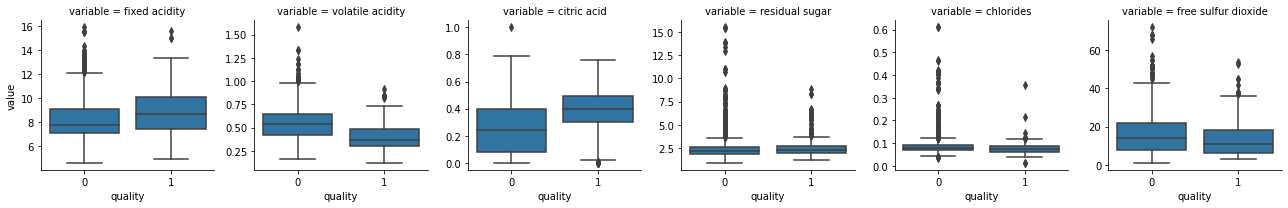

In [8]:
# now let's explore the data with boxplots

# reorganise for plotting
df = data.melt(id_vars=['quality'])

# capture variables
cols = df.variable.unique()

# plot first 6 columns
g = sns.axisgrid.FacetGrid(df[df.variable.isin(cols[0:6])], col='variable', sharey=False)
g.map(sns.boxplot, 'quality','value')
plt.show()

C:\Users\Sole\Documents\Repositories\envs\fenotebook\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


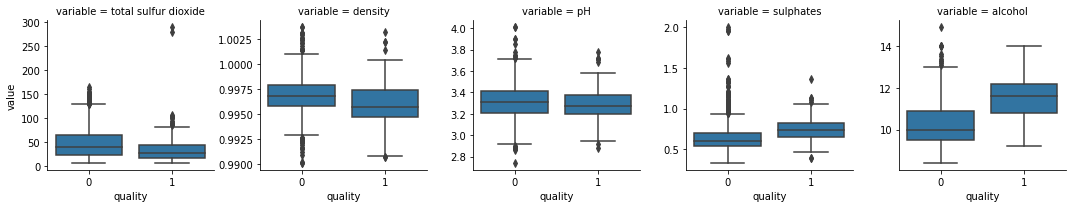

In [9]:
# plot remaining columns
g = sns.axisgrid.FacetGrid(df[df.variable.isin(cols[6:])], col='variable', sharey=False)
g.map(sns.boxplot, 'quality','value')
plt.show()

In [10]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


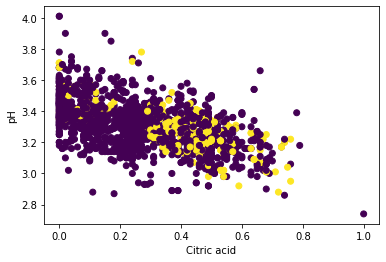

In [11]:
# the citric acid affects the pH of the wine

plt.scatter(data['citric acid'], data['pH'], c=data['quality'])
plt.xlabel('Citric acid')
plt.ylabel('pH')
plt.show()

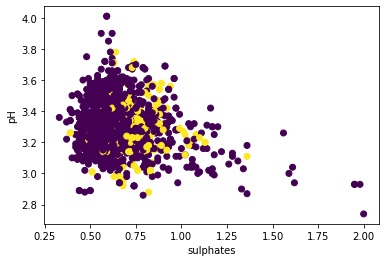

In [12]:
# the sulphates may affect the pH of the wine

plt.scatter(data['sulphates'], data['pH'], c=data['quality'])
plt.xlabel('sulphates')
plt.ylabel('pH')
plt.show()

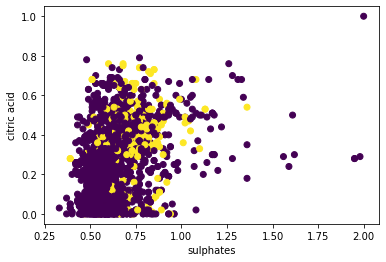

In [13]:
plt.scatter(data['sulphates'], data['citric acid'], c=data['quality'])
plt.xlabel('sulphates')
plt.ylabel('citric acid')
plt.show()

Good quality wine tend to have more citric acid and more sulphate, thus similar pH.

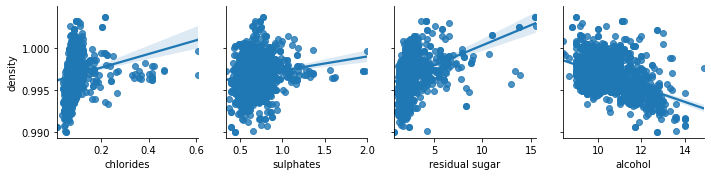

In [14]:
# let's evaluate the relationship between some molecules and the density of the wine

g = sns.PairGrid(data, y_vars=["density"], x_vars=['chlorides','sulphates', 'residual sugar', 'alcohol'])
g.map(sns.regplot)
plt.show()

## Create additional variables

Let's combine variables into new ones to capture additional information.

In [15]:
# combine fixed and volatile acidity to create total acidity
# and mean acidity

combinator = MathematicalCombination(
    variables_to_combine=['fixed acidity', 'volatile acidity'],
    math_operations = ['sum', 'mean'],
    new_variables_names = ['total_acidity', 'average_acidity']
)

data = combinator.fit_transform(data)

# note the new variables at the end of the dataframe
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,total_acidity,average_acidity
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,8.10,4.05
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,8.68,4.34
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,8.56,4.28
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0,11.48,5.74
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,8.10,4.05


In [16]:
# let's combine salts into total minerals and average minerals

combinator = MathematicalCombination(
    variables_to_combine=['chlorides', 'sulphates'],
    math_operations = ['sum', 'mean'],
    new_variables_names = ['total_minerals', 'average_minerals']
)

data = combinator.fit_transform(data)

# note the new variable at the end of the dataframe
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,total_acidity,average_acidity,total_minerals,average_minerals
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,8.10,4.05,0.636,0.3180
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,8.68,4.34,0.778,0.3890
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,8.56,4.28,0.742,0.3710
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0,11.48,5.74,0.655,0.3275
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,8.10,4.05,0.636,0.3180


In [17]:
# let's determine the sulfur that is not free

combinator = CombineWithReferenceFeature(
    variables_to_combine=['total sulfur dioxide'],
    reference_variables=['free sulfur dioxide'],
    operations=['sub'],
    new_variables_names=['non_free_sulfur_dioxide']
)

data = combinator.fit_transform(data)

# note the new variable at the end of the dataframe
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,total_acidity,average_acidity,total_minerals,average_minerals,non_free_sulfur_dioxide
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,8.10,4.05,0.636,0.3180,23.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,8.68,4.34,0.778,0.3890,42.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,8.56,4.28,0.742,0.3710,39.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0,11.48,5.74,0.655,0.3275,43.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,8.10,4.05,0.636,0.3180,23.0


In [18]:
# let's calculate the % of free sulfur

combinator = CombineWithReferenceFeature(
    variables_to_combine=['free sulfur dioxide'],
    reference_variables=['total sulfur dioxide'],
    operations=['div'],
    new_variables_names=['percentage_free_sulfur']
)

data = combinator.fit_transform(data)

# note the new variable at the end of the dataframe
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,total_acidity,average_acidity,total_minerals,average_minerals,non_free_sulfur_dioxide,percentage_free_sulfur
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,8.10,4.05,0.636,0.3180,23.0,0.323529
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,8.68,4.34,0.778,0.3890,42.0,0.373134
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,8.56,4.28,0.742,0.3710,39.0,0.277778
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0,11.48,5.74,0.655,0.3275,43.0,0.283333
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,8.10,4.05,0.636,0.3180,23.0,0.323529


In [19]:
# let's determine from all free sulfur how much is as salt

combinator = CombineWithReferenceFeature(
    variables_to_combine=['sulphates'],
    reference_variables=['free sulfur dioxide'],
    operations=['div'],
    new_variables_names=['percentage_salt_sulfur']
)

data = combinator.fit_transform(data)

# note the new variable at the end of the dataframe
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,total_acidity,average_acidity,total_minerals,average_minerals,non_free_sulfur_dioxide,percentage_free_sulfur,percentage_salt_sulfur
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,8.10,4.05,0.636,0.3180,23.0,0.323529,0.050909
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,8.68,4.34,0.778,0.3890,42.0,0.373134,0.027200
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,8.56,4.28,0.742,0.3710,39.0,0.277778,0.043333
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0,11.48,5.74,0.655,0.3275,43.0,0.283333,0.034118
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,8.10,4.05,0.636,0.3180,23.0,0.323529,0.050909


C:\Users\Sole\Documents\Repositories\envs\fenotebook\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


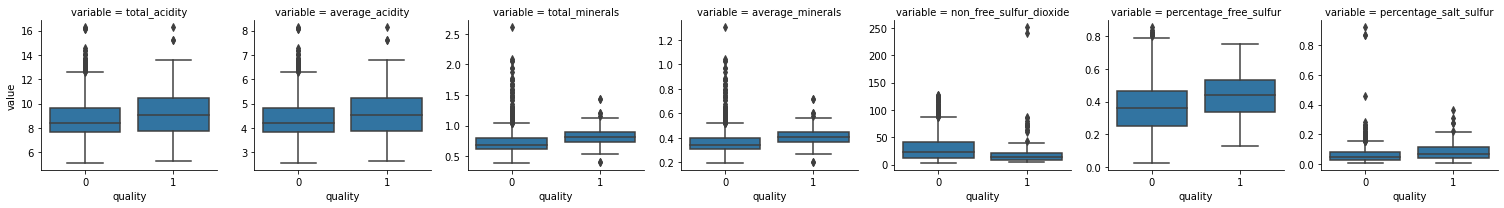

In [20]:
# now let's explore the new variables with boxplots

new_vars = [
    'total_acidity',
    'average_acidity',
    'total_minerals',
    'average_minerals',
    'non_free_sulfur_dioxide',
    'percentage_free_sulfur',
    'percentage_salt_sulfur']

# reorganise for plotting
df = data[new_vars+['quality']].melt(id_vars=['quality'])

# capture variables
cols = df.variable.unique()

# plot first 6 columns
g = sns.axisgrid.FacetGrid(df[df.variable.isin(cols)], col='variable', sharey=False)
g.map(sns.boxplot, 'quality','value')
plt.show()

## Machine Learning Pipeline

Now we are going to carry out all variable creation within a Scikit-learn Pipeline and add a classifier at the end.

In [21]:
data = pd.read_csv('winequality-red.csv', sep=';')

# make binary target
data['quality'] = np.where(data['quality'] <= 6, 0, 1)

# separate dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['quality'], axis=1),
    data['quality'],
    test_size=0.2,
    random_state=0)

X_train.shape, X_test.shape

((1279, 11), (320, 11))

In [22]:
pipe = Pipeline([
    # variable creation
    ('acidity', MathematicalCombination(
        variables_to_combine=['fixed acidity', 'volatile acidity'],
        math_operations = ['sum', 'mean'],
        new_variables_names = ['total_acidity', 'average_acidity']
        )
    ),
    
    ('total_minerals', MathematicalCombination(
        variables_to_combine=['chlorides', 'sulphates'],
        math_operations = ['sum', 'mean'],
        new_variables_names = ['total_minerals', 'average_minearals'],
        )
    ),
    
    ('non_free_sulfur', CombineWithReferenceFeature(
        variables_to_combine=['total sulfur dioxide'],
        reference_variables=['free sulfur dioxide'],
        operations=['sub'],
        new_variables_names=['non_free_sulfur_dioxide'],
        )
    ),
    
    ('perc_free_sulfur', CombineWithReferenceFeature(
        variables_to_combine=['free sulfur dioxide'],
        reference_variables=['total sulfur dioxide'],
        operations=['div'],
        new_variables_names=['percentage_free_sulfur'],
        )
    ),
    
    ('perc_salt_sulfur', CombineWithReferenceFeature(
        variables_to_combine=['sulphates'],
        reference_variables=['free sulfur dioxide'],
        operations=['div'],
        new_variables_names=['percentage_salt_sulfur'],
        )
    ),
    
    # =====  the machine learning model ====
    
    ('gbm', GradientBoostingClassifier(n_estimators=10, max_depth=2, random_state=1)),
])

# create new variables, and then train gradient boosting machine
# uses only the training dataset

pipe.fit(X_train, y_train)

Pipeline(steps=[('acidity',
                 MathematicalCombination(math_operations=['sum', 'mean'],
                                         new_variables_names=['total_acidity',
                                                              'average_acidity'],
                                         variables_to_combine=['fixed acidity',
                                                               'volatile '
                                                               'acidity'])),
                ('total_minerals',
                 MathematicalCombination(math_operations=['sum', 'mean'],
                                         new_variables_names=['total_minerals',
                                                              'average_minearals'],
                                         variables_to_combine...
                                             reference_variables=['total '
                                                                  'sulfur '
                

In [23]:
# make predictions and determine model performance

# the pipeline takes in the raw data, creates all the new features and then
# makes the prediction with the model trained on the final subset of variables

# obtain predictions and determine model performance

pred = pipe.predict_proba(X_train)
print('Train roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))

pred = pipe.predict_proba(X_test)
print('Test roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

Train roc-auc: 0.8884522340404694
Test roc-auc: 0.8693103448275863


## Feature importance

In [24]:
new_vars = ['total_acidity', 'average_acidity', 'total_minerals', 'average_minearals',
           'non_free_sulfur_dioxide', 'percentage_free_sulfur','percentage_salt_sulfur']

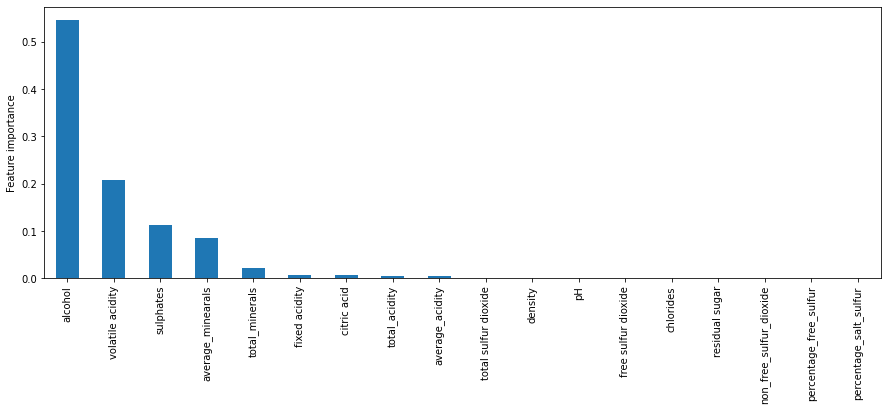

In [25]:
importance = pd.Series(pipe.named_steps['gbm'].feature_importances_)
importance.index = list(X_train.columns) + new_vars

importance.sort_values(ascending=False).plot.bar(figsize=(15,5))
plt.ylabel('Feature importance')
plt.show()

We see that some of the variables that we created are somewhat important for the prediction, like average_minerals, total_minerals, and total and average acidity.

That is all folks!


## References and further reading

- [Feature-engine](https://feature-engine.readthedocs.io/en/latest/index.html), Python open-source library
- [Python Feature Engineering Cookbook](https://www.packtpub.com/data/python-feature-engineering-cookbook)

## Other Kaggle kernels featuring Feature-engine

- [Feature selection for bank customer satisfaction prediction](https://www.kaggle.com/solegalli/feature-selection-with-feature-engine)
- [Feature engineering and selection for house price prediction](https://www.kaggle.com/solegalli/predict-house-price-with-feature-engine)